**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, H, W), where the output needs to have (N, 12, H, W).

For each label tensor (H, W):
Each entry represents which join a location contains: value 1-11 are joints 1 to 11, value 0 represents no-joints at this location.

In [86]:
# Loading our own functions
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()
    
# define some constants
num_joints = 21
image_size = 224
batch_size = 10
dtype = torch.float32

transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 100 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    heatmap = torch.zeros((pos2d_list.shape[0], pos2d_list.shape[1], image_size, image_size)) # size (N, 21, 224, 224)
    loc_map_x = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_y = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_z = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            loc_map_x[b, i, pos2d_list[b, i, 1].long(), pos2d_list[b, i, 0].long()] = pos3d_list[b, i, 0].float()
            loc_map_y[b, i, pos2d_list[b, i, 1].long(), pos2d_list[b, i, 0].long()] = pos3d_list[b, i, 1].float()
            loc_map_z[b, i, pos2d_list[b, i, 1].long(), pos2d_list[b, i, 0].long()] = pos3d_list[b, i, 2].float()
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            heatmap[b, i, int(y), int(x)] = 1.0 - (delta_x**2 + delta_y**2) / 32
                                
    print(heatmap.shape)
    # TODO: can we just have data as float by default? not double

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    print(loc_map.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([10, 3, 224, 224])
0 torch.Size([10, 21, 2])
0 torch.Size([10, 21, 3])
torch.Size([10, 21, 224, 224])
torch.Size([10, 63, 224, 224])


Epoch: 0
Loss: 14.070234298706055
Loss: 14.272265434265137
Loss: 14.341334342956543
Loss: 14.671313285827637
Loss: 15.24515151977539
Loss: 14.752921104431152
Loss: 14.741732597351074
Loss: 14.346747398376465
Epoch: 1
Loss: 14.299721717834473
Loss: 13.572790145874023
Loss: 12.698362350463867
Loss: 13.173918724060059
Loss: 13.429287910461426
Loss: 12.414506912231445
Loss: 12.958395004272461
Loss: 13.038570404052734
Epoch: 2
Loss: 12.028671264648438
Loss: 12.802583694458008
Loss: 11.617486953735352
Loss: 12.84177017211914
Loss: 13.059148788452148
Loss: 12.032358169555664
Loss: 11.940967559814453
Loss: 11.639433860778809
Epoch: 3
Loss: 11.359220504760742
Loss: 11.342302322387695
Loss: 11.20265007019043
Loss: 11.41351318359375
Loss: 11.300653457641602
Loss: 11.230768203735352
Loss: 10.768593788146973
Loss: 10.914095878601074
Epoch: 4
Loss: 10.71782112121582
Loss: 10.21916389465332
Loss: 10.206305503845215
Loss: 9.639152526855469
Loss: 9.703039169311523
Loss: 9.400263786315918
Loss: 9.567872

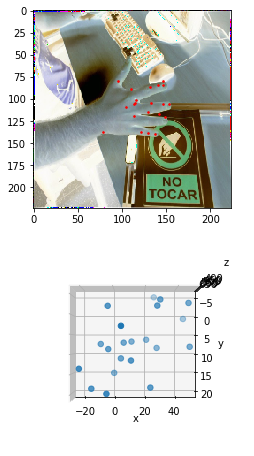

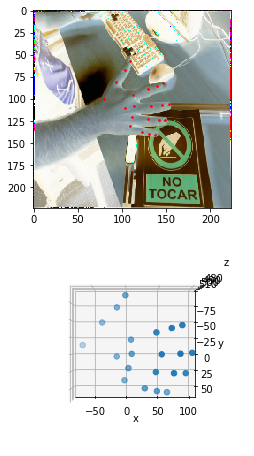

Eval Loss: 9.663914680480957


In [114]:
def makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_y = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_z = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            heatmap[b, i, int(y), int(x)] = 1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot


def computeLoss(heatmap, one_hot, loc_map, y_pred, batch_size, num_joints, image_size):
    l_loss = 0.0001 * torch.sum(torch.pow(heatmap.repeat(1, 3, 1, 1) * (y_pred[:, 0:63, :, :] - loc_map), 2)) / (batch_size * num_joints * 9**2 * 3)
    hmap_pred = nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2)
    h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, 21, -1), dim=2)
    h_loss = torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
    #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size
    loss = l_loss + h_loss
    return loss

def makePosList(y_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(y_pred[0, 63:, :, :].view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = y_pred[0, 0:21, :, :].data.numpy()
    p3d_x = p3d_x[np.arange(len(p3d_x)), p2d_y, p2d_x]

    p3d_y = y_pred[0, 21:42, :, :].data.numpy()
    p3d_y = p3d_y[np.arange(len(p3d_y)), p2d_y, p2d_x]

    p3d_z = y_pred[0, 42:63, :, :].data.numpy()
    p3d_z = p3d_z[np.arange(len(p3d_z)), p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d
    
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False

# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# finally, the join prediction Convolutional Layer, filter size 3 x 3, 21 + 1 = 22 filters?
# The +1 (filter dimension 11) is used to denote that the location does not correspond to any joints
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=64, out_channels=84, kernel_size=3, stride=1, padding=1)

# stick a bunch of ReLu non-linearity in the upsampling pipeline

model = nn.Sequential(
    *list(resnet34.children())[:-2],
    transConv1,
    nn.ReLU(),
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
    jointPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU

# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)

for epoch in range(20):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
        # y_pred is of size 224 x 224 x 84, and let's say the filter dimension is layed out in the following way:
        # dimension 0-20: j1_x, j2_x, j3_x,...j21_x, dimension 21-41: j1_y, j2_y, j3_y, ... 
        # Above is for conveniently using broadcasting with heatmap element-wise product
        # y_pred is the predicted location maps + 2Dheatmap for all 21 joints
        y_pred = model(image)
        #print("output shape: {}".format(y_pred.shape))
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, y_pred, batch_size, num_joints, image_size)
        print("Loss: {}".format(loss))
        loss.backward()
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
print("Evaluation...")
eval_loss = 0
eval_iter = 0
for idx, batch in enumerate(loader_val):
    eval_iter = idx
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    y_pred = model(image)
    
    loss = computeLoss(heatmap, one_hot, loc_map, y_pred, batch_size, num_joints, image_size)
    
    eval_loss = eval_loss + loss
    
    if idx == 0:
        # show some images
        p2d, p3d = makePosList(y_pred)
        show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
        show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])

eval_iter = eval_iter + 1
print("Eval Loss: {}".format(eval_loss / eval_iter))